pybullet build time: Nov 28 2023 23:45:17


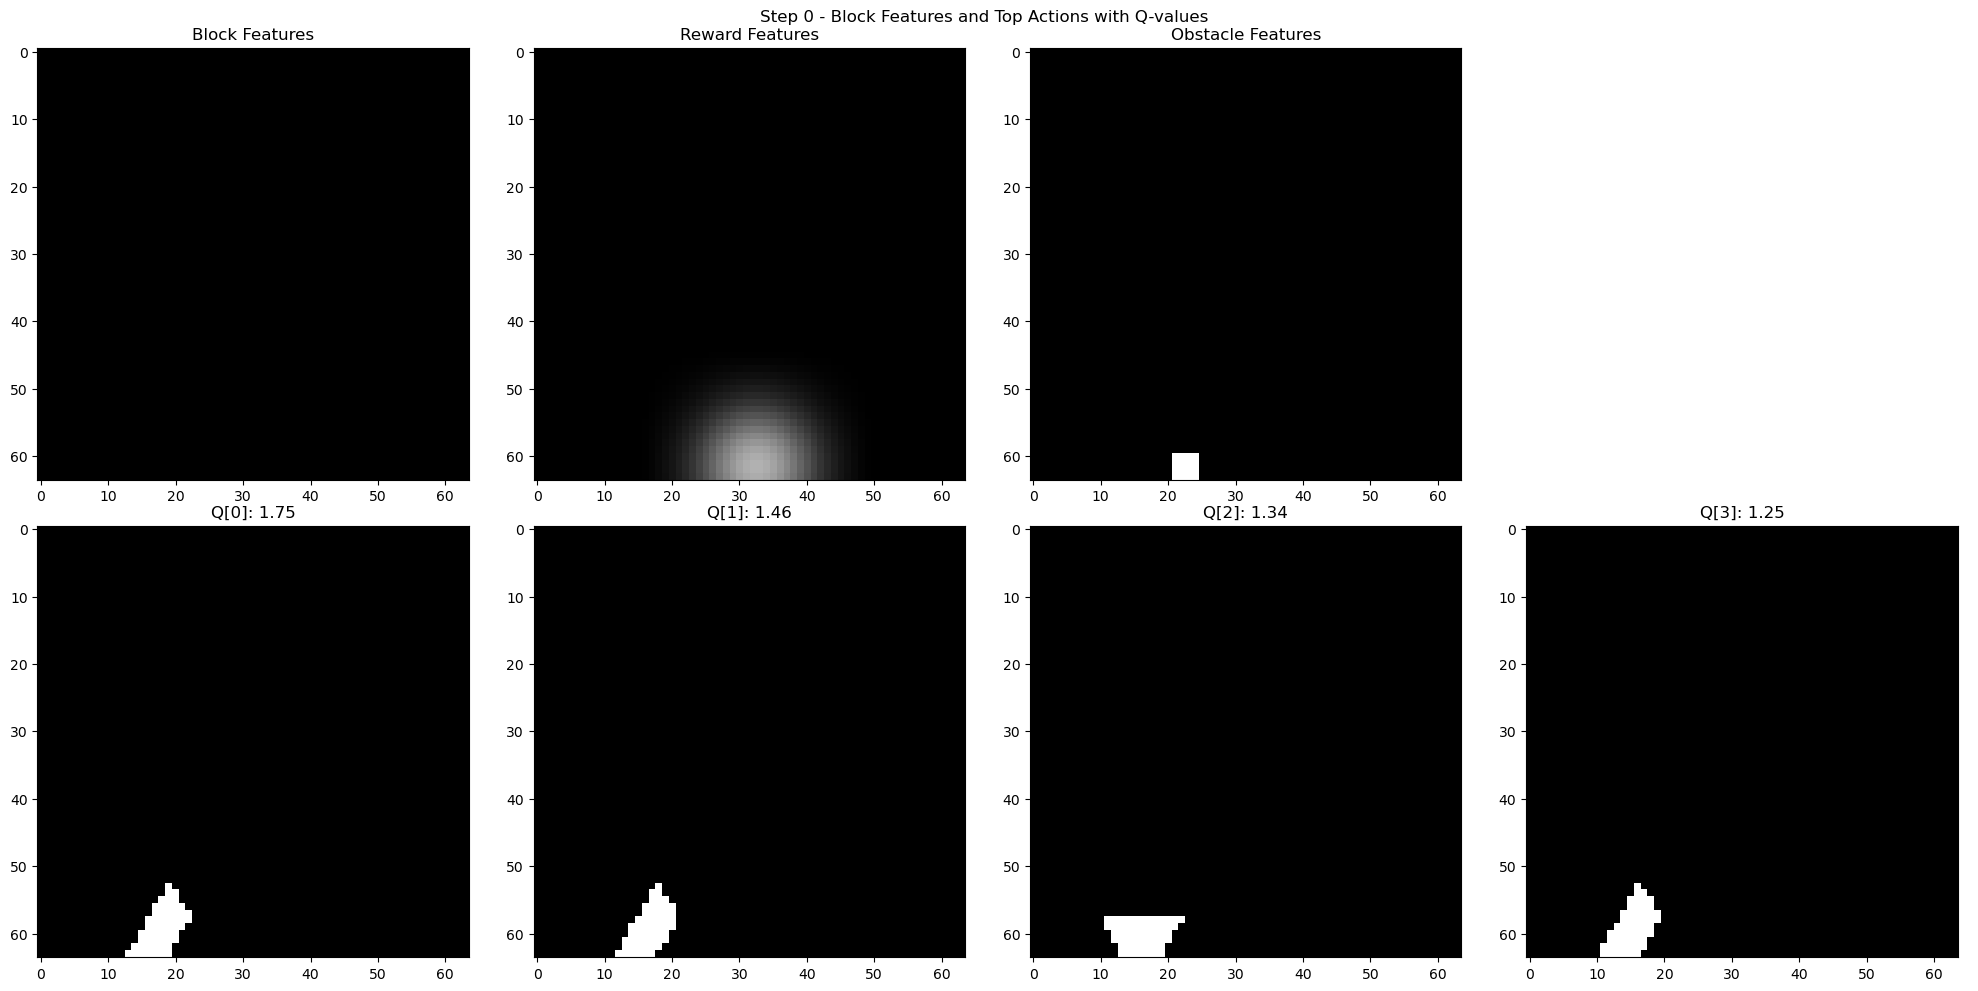

  0%|          | 0/10 [00:00<?, ?it/s]


Top Q-values and their actions:
0: Q-value: 1.75, Action: Action(target_block=-1, target_face=0, shape=0, face=2, offset_x=-0.44444444444444464, offset_y=0.0, frozen=False)
1: Q-value: 1.46, Action: Action(target_block=-1, target_face=0, shape=0, face=2, offset_x=-0.6666666666666667, offset_y=0.0, frozen=False)
2: Q-value: 1.34, Action: Action(target_block=-1, target_face=0, shape=0, face=1, offset_x=-0.44444444444444464, offset_y=0.0, frozen=False)
3: Q-value: 1.25, Action: Action(target_block=-1, target_face=0, shape=0, face=2, offset_x=-0.8888888888888888, offset_y=0.0, frozen=False)
Enter a number between 0 and 3 or -1 to quit


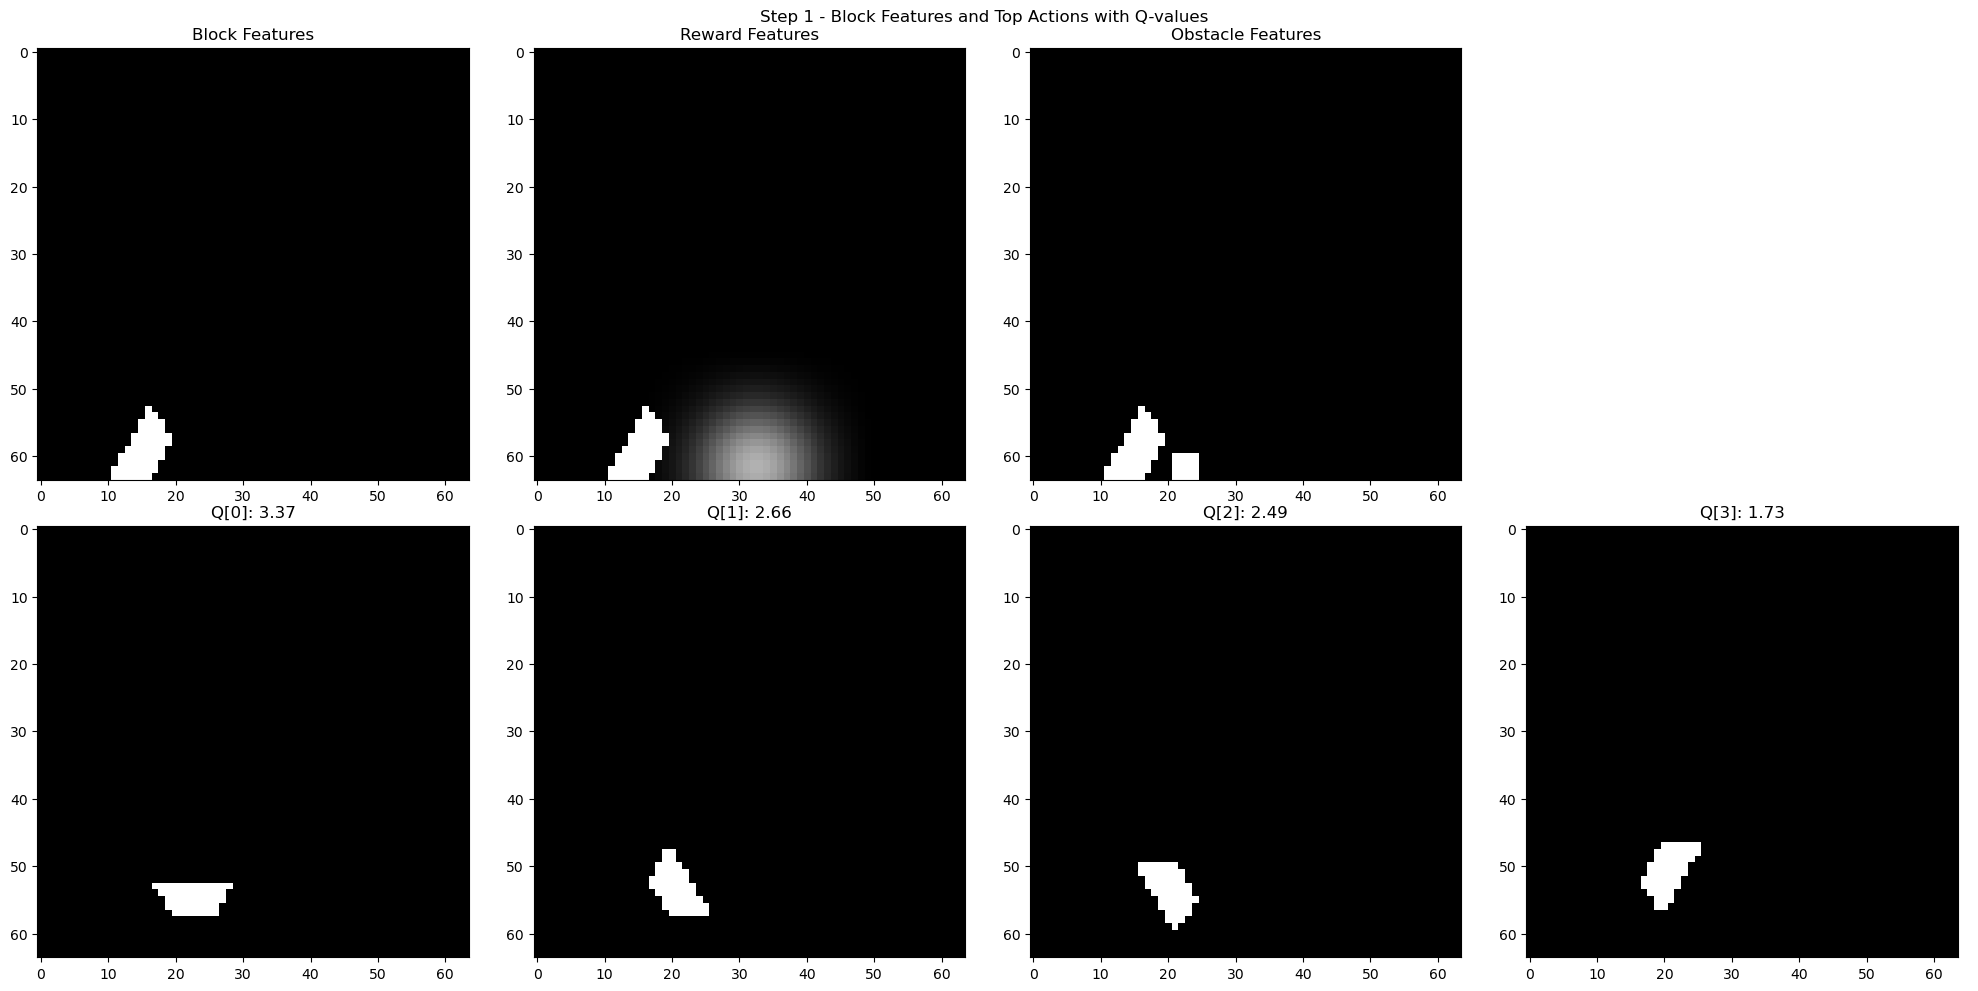


Top Q-values and their actions:
0: Q-value: 3.37, Action: Action(target_block=0, target_face=0, shape=0, face=2, offset_x=0.0, offset_y=0.0, frozen=False)
1: Q-value: 2.66, Action: Action(target_block=0, target_face=0, shape=0, face=1, offset_x=0.0, offset_y=0.0, frozen=False)
2: Q-value: 2.49, Action: Action(target_block=0, target_face=0, shape=0, face=3, offset_x=0.0, offset_y=0.0, frozen=False)
3: Q-value: 1.73, Action: Action(target_block=0, target_face=0, shape=0, face=0, offset_x=0.0, offset_y=0.0, frozen=False)
Enter a number between 0 and 3 or -1 to quit


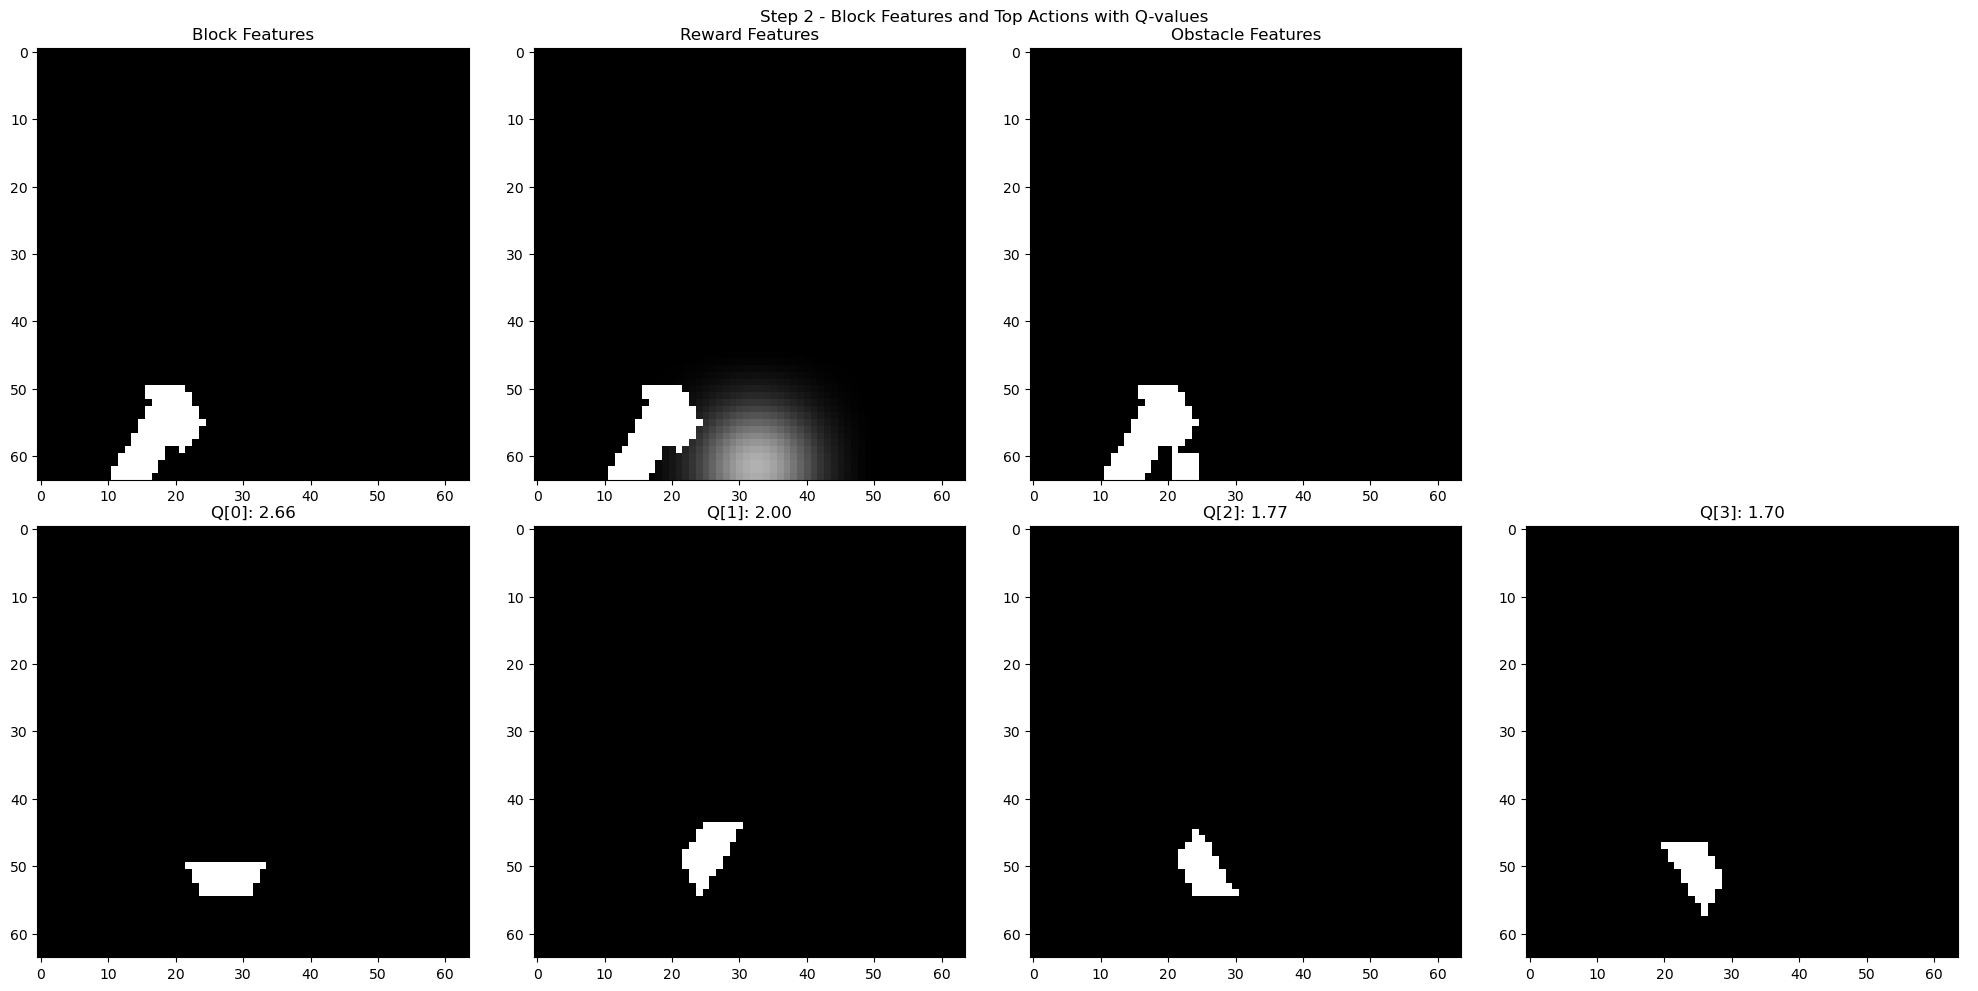


Top Q-values and their actions:
0: Q-value: 2.66, Action: Action(target_block=1, target_face=1, shape=0, face=2, offset_x=0.0, offset_y=0.0, frozen=False)
1: Q-value: 2.00, Action: Action(target_block=1, target_face=1, shape=0, face=0, offset_x=0.0, offset_y=0.0, frozen=False)
2: Q-value: 1.77, Action: Action(target_block=1, target_face=1, shape=0, face=1, offset_x=0.0, offset_y=0.0, frozen=False)
3: Q-value: 1.70, Action: Action(target_block=1, target_face=1, shape=0, face=3, offset_x=0.0, offset_y=0.0, frozen=False)
Enter a number between 0 and 3 or -1 to quit


In [1]:
import torch
from assembly_gym.envs.gym_env import AssemblyGym, sparse_reward, horizontal_bridge_setup
from assembly_gym.envs.assembly_env import AssemblyEnv, Block, Shape
import wandb
from robotoddler.models.cv import Policy
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple
from robotoddler.utils.actions import generate_actions, filter_actions
from assembly_gym.utils.rendering import render_blocks_2d, get_rgb_array
from robotoddler.utils.utils import convolve_with_gaussian
from tqdm.auto import tqdm
from ipywidgets import interact, IntSlider
from robotoddler.training.successor_dqn import rollout_episode_scripted, log_episode

# Define your Transition namedtuple
Transition = namedtuple('Transition',
                        ('block_features', 'binary_features', 'action', 'action_features', 'reward',
                         'lin_reward', 'done', 'reward_features', 'obstacle_features', 'next_block_features',
                         'next_binary_features', 'next_available_actions', 'next_actions_features', 'next_reward_features',
                         'next_obstacle_features', 'q_values'))  # Added q_values here

def get_state_features(observation, xlim=(0, 1), ylim=(0, 1), img_size=(512,512), device=None):
    binary_features = np.array([
        observation['stable'],
        observation['collision'],
        observation['collision_block'],
        observation['collision_obstacle'],
        observation['collision_floor'],
        observation['collision_boundary'],
    ])
    image_features = torch.Tensor(render_blocks_2d(observation['blocks'], xlim=xlim, ylim=ylim, img_size=img_size)).unsqueeze(0).to(device)
    return image_features, torch.Tensor(binary_features).to(device)

def get_task_features(obs, xlim=(0, 1), ylim=(0, 1), img_size=(512,512), device=None):
    cube = Shape(urdf_file='shapes/cube06.urdf')
    target_blocks = [Block(shape=cube, position=target) for target in obs['targets']]
    reward_features = render_blocks_2d(target_blocks, xlim=xlim, ylim=ylim, img_size=img_size).astype(np.float32)
    kernel_size = 31
    sigma = 8
    reward_features = convolve_with_gaussian(torch.Tensor(reward_features), kernel_size, sigma)
    obstacle_features = render_blocks_2d(obs['obstacle_blocks'], xlim=xlim, ylim=ylim, img_size=img_size)
    return reward_features.unsqueeze(0).to(device), torch.Tensor(obstacle_features).unsqueeze(0).to(device)

def get_action_features(env, actions, xlim=(0,1), ylim=(0, 1), img_size=(512,512), device=None):
    blocks = [env.create_block(action) for action in actions]
    return torch.Tensor(np.array([render_blocks_2d([block], xlim=xlim, ylim=ylim, img_size=img_size) for block in blocks])).unsqueeze(1).to(device)

# Define the environment and load the policy network
x_discr_ground = np.linspace(-2, 0, 10)
xlim = (-3, 7)
ylim = (0., 10)

env = AssemblyGym(reward_fct=sparse_reward, max_steps=10, restrict_2d=True, assembly_env=AssemblyEnv(render=False))

policy_net = Policy().to('cpu')
policy_net.load_state_dict(torch.load('policy_net.pth'))
policy_net.eval()

def setup_fct():
    return horizontal_bridge_setup(num_obstacles=6)


# Function to plot the top Q-values and corresponding actions
def plot_top_q_values(block_features, reward_features, obstacle_features, top_q_values, top_actions, step, env, xlim=(0, 1), ylim=(0, 1), img_size=(64, 64)):
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    
    # Plot the block features in the first row
    axes[0, 0].imshow(block_features.squeeze().cpu().numpy(), cmap='gray', vmin=0, vmax=1)
    axes[0, 0].set_title('Block Features')

    axes[0, 1].imshow(10 * reward_features.squeeze().cpu().numpy() + block_features.squeeze().cpu().numpy(), cmap='gray', vmin=0, vmax=1)
    axes[0, 1].set_title('Reward Features')

    axes[0, 2].imshow(obstacle_features.squeeze().cpu().numpy()+block_features.squeeze().cpu().numpy(), cmap='gray', vmin=0, vmax=1)
    axes[0, 2].set_title('Obstacle Features')
    
    # Leave the last plot in the first row empty
    axes[0, 3].axis('off')

    # Plot the top actions and their Q-values in the second row
    for i in range(len(top_q_values)):
        action_img = render_blocks_2d([env.create_block(top_actions[i])], xlim=xlim, ylim=ylim, img_size=img_size)
        axes[1, i].imshow(action_img, cmap='gray', vmin=0, vmax=1)
        axes[1, i].set_title(f'Q[{i}]: {top_q_values[i].item():.2f}')

    for i in range(len(top_q_values), 4):
        axes[1, i].axis('off')

    fig.suptitle(f'Step {step} - Block Features and Top Actions with Q-values')
    plt.tight_layout()
    plt.show()

    

def rollout_episode(env, policy_net, x_discr_ground, setup_fct, offset_values=[0.], img_size=(64, 64), xlim=(0,1), ylim=(0,1), device='cpu'):
    done = False
    transitions = []

    obs, info = env.reset(**setup_fct())
    reward_features, obstacle_features = get_task_features(obs, img_size=img_size, device=device, xlim=xlim, ylim=ylim)
    block_features, binary_features = get_state_features(obs, img_size=img_size, device=device, xlim=xlim, ylim=ylim)
    available_actions = [*generate_actions(env, x_discr_ground=x_discr_ground, offset_values=offset_values)]
    action_features = get_action_features(env, available_actions, img_size=img_size, device=device, xlim=xlim, ylim=ylim)
    available_actions, action_features = filter_actions(env, available_actions, action_features, block_features=block_features, obstacle_features=obstacle_features, xlim=xlim, ylim=ylim)
    num_actions = len(available_actions)

    while not done:
        with torch.no_grad():
            q_values, succ_block_features, succ_binary_features = policy_net(block_features.expand(num_actions, -1, -1, -1),
                                                   binary_features.expand(num_actions, -1),
                                                   action_features, 
                                                   reward_features.expand(num_actions, -1, -1, -1),
                                                   obstacle_features.expand(num_actions, -1, -1, -1))
        
        # Sort the Q-values and get the top indices
        sorted_indices = torch.argsort(q_values, descending=True)
        top_q_values_indices = sorted_indices[:4]
        top_q_values = q_values[top_q_values_indices]
        top_actions = [available_actions[i.item()] for i in top_q_values_indices]

        # Yield the current state, top Q-values, and actions
        selected_action_rank = yield block_features, binary_features, reward_features, obstacle_features, top_q_values, top_actions, q_values

        # Map the selected action rank back to the original action index
        selected_action_index = top_q_values_indices[selected_action_rank].item()
        
        action = available_actions[selected_action_index]
        selected_action_features = action_features[selected_action_index]
        next_observation, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        frozen_stable, unfrozen_stable = env.stabilities_freezing()
        lin_reward = torch.zeros(1, device=device).view(-1)
        if frozen_stable:
            lin_reward = torch.sum(selected_action_features * reward_features).view(-1) / 100
        if unfrozen_stable:
            lin_reward = torch.sum(selected_action_features * reward_features).view(-1)

        next_block_features, next_binary_features = get_state_features(next_observation, img_size=img_size, device=device, xlim=xlim, ylim=ylim)
        next_available_actions = [*generate_actions(env, x_discr_ground=x_discr_ground, offset_values=offset_values)]
        next_action_features = get_action_features(env, next_available_actions, img_size=img_size, device=device, xlim=xlim, ylim=ylim)
        next_available_actions, next_action_features = filter_actions(env, next_available_actions, next_action_features, next_block_features, obstacle_features=obstacle_features, xlim=xlim, ylim=ylim)
        num_actions = len(next_available_actions)
        
        if len(next_available_actions) == 0:
            done = True
            next_action_features = torch.zeros([1,1,*img_size], device=device)
        
        transitions.append(Transition(
            block_features=block_features.unsqueeze(0),
            binary_features=binary_features.unsqueeze(0),
            action_features=action_features[selected_action_index].unsqueeze(0),
            reward_features=reward_features.unsqueeze(0),
            obstacle_features=obstacle_features.unsqueeze(0),
            action=action,
            lin_reward=lin_reward.unsqueeze(0),
            reward=torch.Tensor([reward]),
            done=done,
            next_block_features=next_block_features.expand(max(1,num_actions), -1, -1, -1),
            next_binary_features=next_binary_features.expand(max(1,num_actions), -1),
            next_actions_features=next_action_features,
            next_reward_features=reward_features.expand(max(1,num_actions), -1, -1, -1),
            next_obstacle_features=obstacle_features.expand(max(1,num_actions), -1, -1, -1),
            next_available_actions=next_available_actions,
            q_values=q_values  # Store Q-values here
        ))
        
        block_features = next_block_features
        binary_features = next_binary_features
        action_features = next_action_features
        available_actions = next_available_actions

    return transitions

def interactive_step():
    episode_generator = rollout_episode(env, policy_net, x_discr_ground, setup_fct, xlim=xlim, ylim=ylim)
    log_info = None

    # Initial state
    block_features, binary_features, reward_features, obstacle_features, top_q_values, top_actions, q_values = next(episode_generator)
    
    # Plot initial state and top Q-values
    plot_top_q_values(block_features, reward_features, obstacle_features, top_q_values, top_actions, step=0, env=env, xlim=xlim, ylim=ylim)
    actions = []
    # Iterate through the episode steps
    for step in tqdm(range(env.max_steps)):
        try:
            selected_action_rank = get_user_action_input(top_q_values, top_actions)
            if selected_action_rank == -1:
                print("Quitting...")
                break
            actions.append(top_actions[selected_action_rank])
            block_features, binary_features, reward_features, obstacle_features, top_q_values, top_actions, q_values = episode_generator.send(selected_action_rank)
            plot_top_q_values(block_features, reward_features, obstacle_features, top_q_values, top_actions, step=step+1, env=env, xlim=xlim, ylim=ylim)
        except StopIteration:
            break
    
    return actions

def get_user_action_input(top_q_values, top_actions):
    print("\nTop Q-values and their actions:")
    for i, (q_value, action) in enumerate(zip(top_q_values, top_actions)):
        print(f"{i}: Q-value: {q_value.item():.2f}, Action: {action}")
    print(f"Enter a number between 0 and {len(top_q_values) - 1} or -1 to quit")
    while True:
        try:
            selected_action_rank = int(input("Select the action index: "))
            if -1 <= selected_action_rank < len(top_q_values):
                return selected_action_rank
            else:
                print(f"Invalid index. Please enter a number between 0 and {len(top_q_values) - 1}.")
        except ValueError:
            print("Invalid input. Please enter a number.")

# Example usage
actions = interactive_step()
gamma = 0.95
transitions, images = rollout_episode_scripted(env, actions, setup_fct, x_discr_ground)
print("reward ", sum([gamma ** i * t.reward for i,t in enumerate(transitions)]).item())
print("stable ", transitions[-1].next_binary_features[0, 0].item())
print("lin reward ", transitions[-1].lin_reward.item())
print("done ", [transitions[i].done for i in range(len(transitions))])

log_info, fig = log_episode(
    episode=0,
    transitions=transitions,
    images=images,
    log_images=True,
    losses=None,
    context='evaluation',
    gamma=gamma,
    aim_run=None
)
